**Тестовое задание. Наталья Юшкевич**

# Задание №1.
Используя исторические данные на листе «Timeseries» (см. Задания_1_2.xlsx), построить модель временного ряда.  

Спрогнозировать  ежедневное поведение ряда в следующие 3 мес.  

Пояснить выбор метода прогнозирования. 

Привести оценки качества прогноза.

**Импорт библиотек.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.tsa.arima.model  import ARIMA
from pandas. tseries.offsets import DateOffset

import warnings
warnings.filterwarnings('ignore')

**Данные.**

Считываем файл с данными. Колонку *Date* будем использовать как индексную, чтобы мы могли манипулировать временными рядами.

In [4]:
df = pd.read_excel('/content/drive/MyDrive/Задания_1_2.xlsx', sheet_name='Timeseries', index_col ='Date', parse_dates = True)
print(f"Количество строк и столбцов:{df.shape}")
df.head()

Количество строк и столбцов:(1642, 1)


,series1
Date,
2015-01-01,1006.699649
2015-01-02,3197.751826
2015-01-03,3217.491035
2015-01-04,2151.573759
2015-01-05,4243.929892


Здесь имеем следующие данные:
* **Date** - дата;
* **series1** - величина, которую нужно будет предсказать в будущем.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1642 entries, 2015-01-01 to 2019-06-30
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   series1  1642 non-null   float64
dtypes: float64(1)
memory usage: 25.7 KB


Пропущенных значений нет. *series1* имеет тип float.

Посмотрим на графики изменения данных во времени.

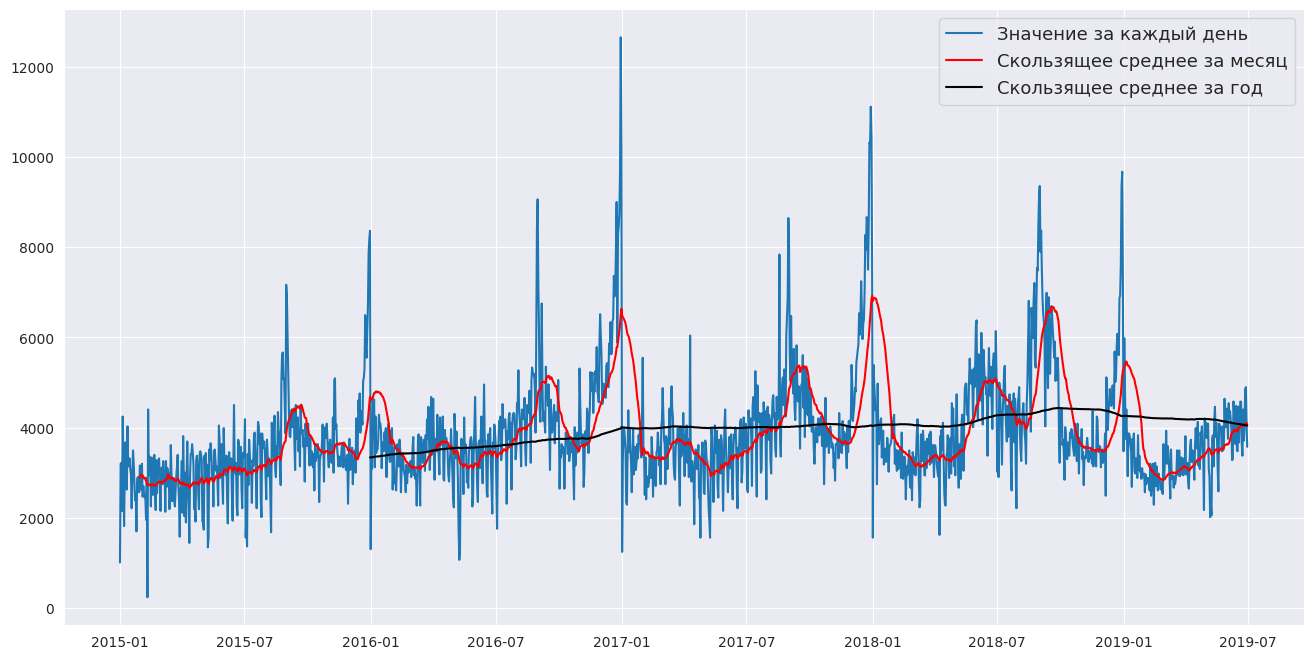

In [6]:
sns.set_style('darkgrid')
plt.figure(figsize = (16, 8))

plt.plot(df, label = 'Значение за каждый день')
plt.plot(df.rolling(window=30).mean(), label='Скользящее среднее за месяц', color='r')
plt.plot(df.rolling(window=365).mean(), label='Скользящее среднее за год', color='k')

plt.legend(fontsize=13)
plt.show();

По графику не просматривается ни тренд ни сезонность. Повидимому ряд стационарный.

Посмотрим теперь на график за 1 год и 1 месяц.

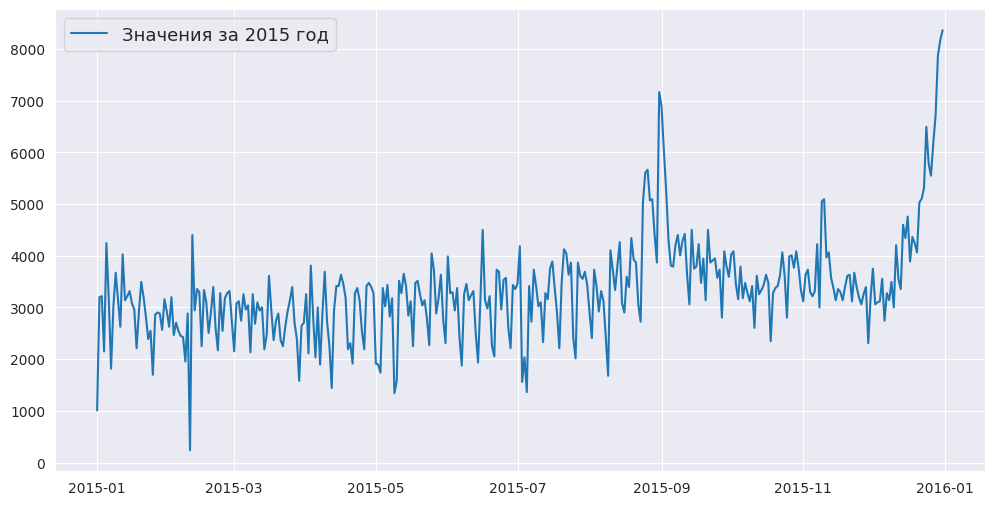

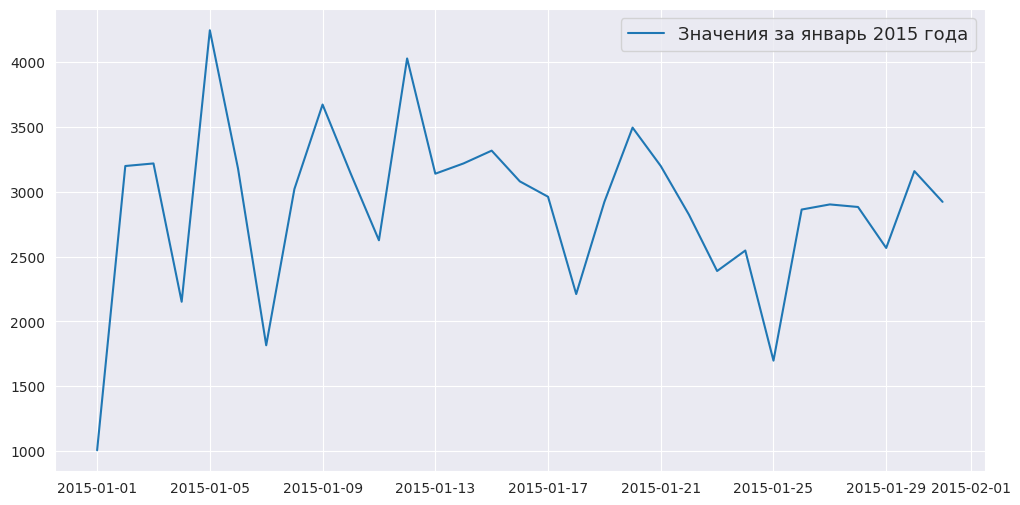

In [7]:
plt.figure(figsize = (12, 6))
plt.plot(df['2015-01-01':'2015-12-31'], label = 'Значения за 2015 год')
plt.legend(fontsize = 13)
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(df['2015-01-01':'2015-01-31'], label = 'Значения за январь 2015 года')
plt.legend(fontsize = 13)
plt.show();

Сизонность не просматривается ни за месяц, ни за неделю.

**Компонены временного ряда.**

Разобьём временной ряд на компоненты.

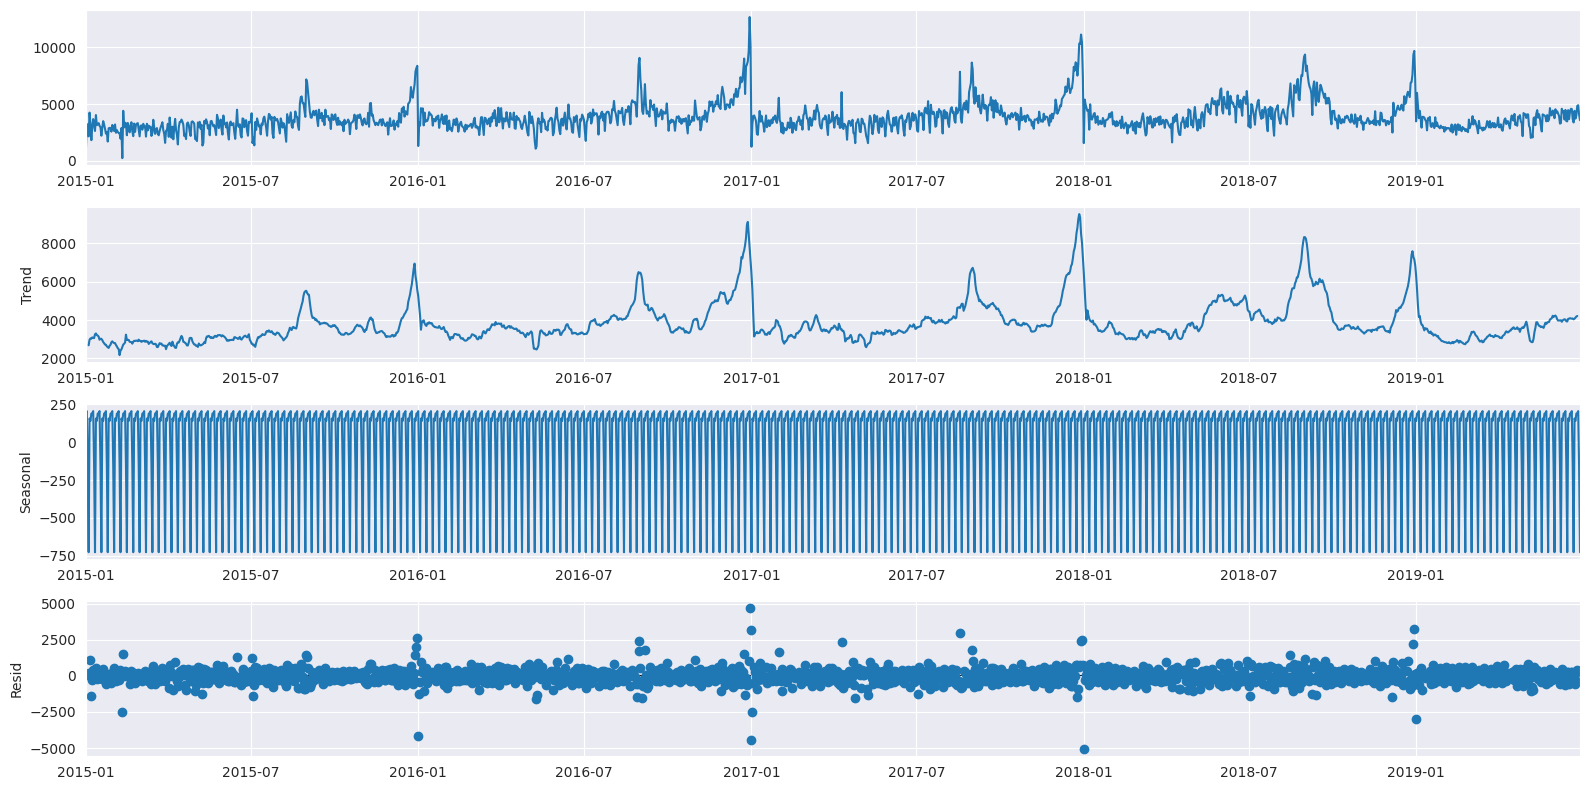

In [8]:
rcParams['figure.figsize'] = 16, 8

decompose = seasonal_decompose(df)
decompose.plot()

plt.show();

Из разложения можно предположить, что мы имеем дело со стационарным временным рядом. Отсутствует тренд и сезонность. Также имеется шум.

Проведем тест Дики-Фуллера, чтобы подтвердить нашу теорию. Нулевая гипотеза - ряд не стационарный, альтернативная - стационарный. Пороговое значение выберем 5% (0,05).

In [9]:
df_test = adfuller(df)
print(f'p-value = {str(df_test[1])}')

p-value = 2.1154012725976475e-06


p-value < 0,05, так что ряд стационарный. 

**Автокорреляция.**

Теперь посмотрим на ACF и PACF граыфики. Нам это нужно, для подбора параметров модели.

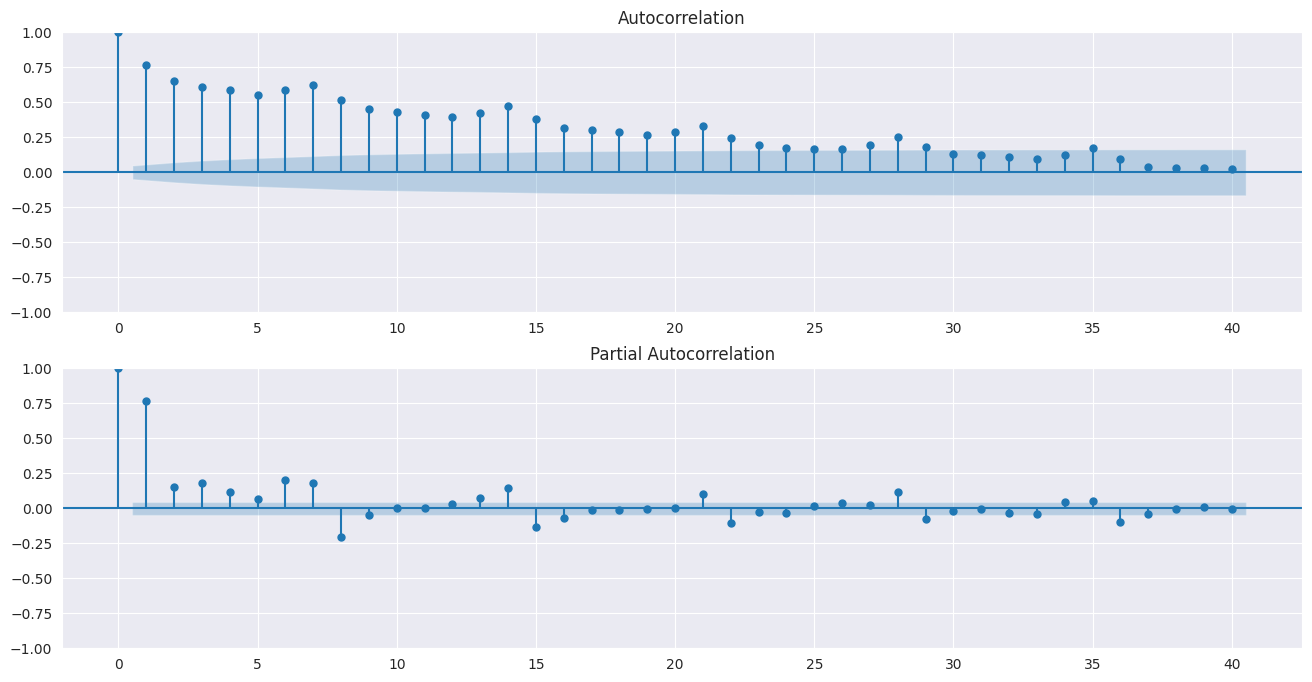

In [10]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=40, ax=ax2)

Здесь можно заметить, что lag 7 коррелирует с исходным рядом сильнее, чем соседние. Такую же картину мы видим каждые 7 лагов. Отсюда можно предположить, что есть еженедельные сезонные колебания. Однако ранее мы уже выяснили, что ряд стационарен.

**Построение модели.**

В данном случае затухающий график ACF и выбросы на первых лагах PACF свидетельствуют о том, что это модель авторегрессии. 

Так как график ACF затухает медленно, то мы можем использовать модель ARIMA(p, d, 0), где p = 8, d = 0, q = 0.

In [46]:
train_df = df[:'2019-03-31']
test_df = df['2019-04-01':]

In [47]:
model = ARIMA(train_df, order=(8, 0, 0))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                series1   No. Observations:                 1551
Model:                 ARIMA(8, 0, 0)   Log Likelihood              -12423.384
Date:                Wed, 12 Apr 2023   AIC                          24866.768
Time:                        08:54:10   BIC                          24920.235
Sample:                    01-01-2015   HQIC                         24886.653
                         - 03-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3863.5132    188.908     20.452      0.000    3493.260    4233.766
ar.L1          0.5921      0.016     36.379      0.000       0.560       0.624
ar.L2          0.0340      0.021      1.611      0.1

In [48]:
start = len(train_df)
end = len(train_df) + len(test_df) -1
predictions = result.predict(start, end)

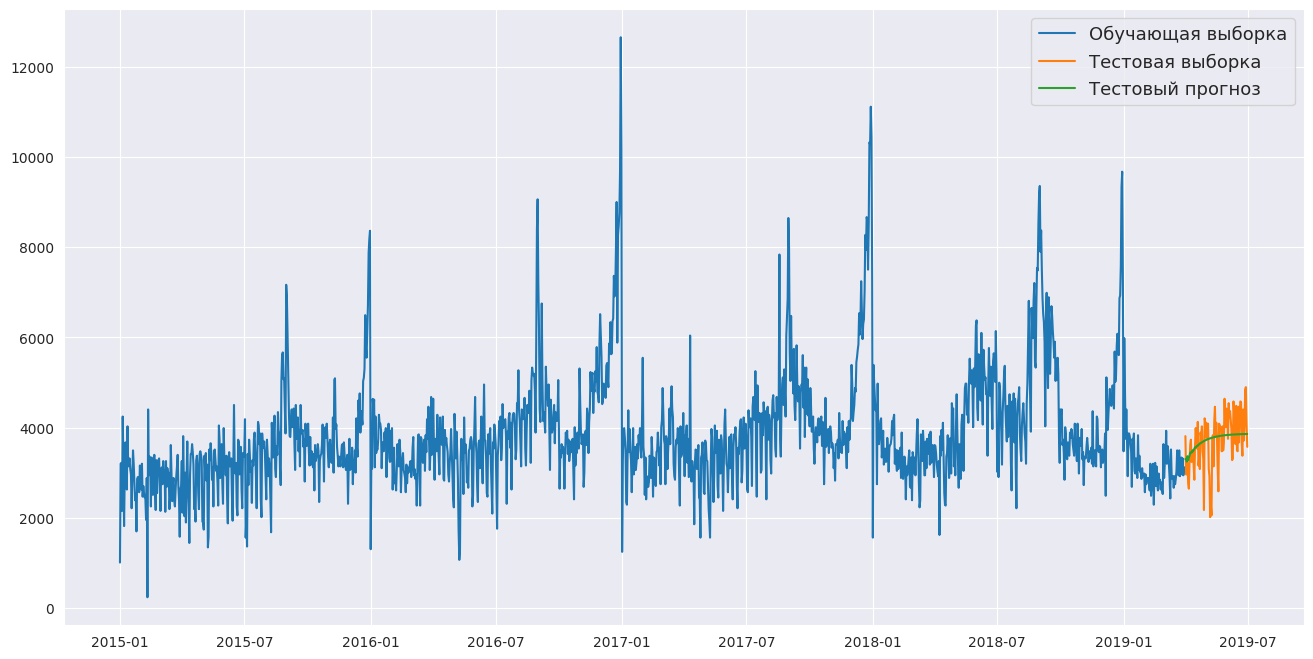

In [49]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train_df, label = 'Обучающая выборка')
plt.plot(test_df, label = 'Тестовая выборка')
plt.plot(predictions, label = 'Тестовый прогноз')

plt.legend(fontsize=13)
plt.show()

Оценка модели.

In [50]:
# импортируем метрику
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# MAPE
print(f'MAPE = {round(mean_absolute_percentage_error(test_df, predictions)*100, 2)} %')
print(f'MAE = {round(mean_absolute_error(test_df, predictions)*100, 2)} %')
print(f'MSE = {round(mean_squared_error(test_df, predictions)*100, 2)} %')

MAPE = 13.07 %
MAE = 43066.91 %
MSE = 31225056.66 %


**Предсказания**

Теперь сделаем предсказания на следующие 3 месяца.

In [51]:
model = ARIMA(df, order=(8, 0, 0))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                series1   No. Observations:                 1642
Model:                 ARIMA(8, 0, 0)   Log Likelihood              -13129.838
Date:                Wed, 12 Apr 2023   AIC                          26279.676
Time:                        08:55:01   BIC                          26333.713
Sample:                    01-01-2015   HQIC                         26299.715
                         - 06-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3854.9751    178.392     21.610      0.000    3505.333    4204.618
ar.L1          0.5889      0.016     37.339      0.000       0.558       0.620
ar.L2          0.0357      0.021      1.738      0.0

In [52]:
pred = result.predict(df.index.max() + DateOffset(days= 1), df.index.max() + DateOffset(months= 3))

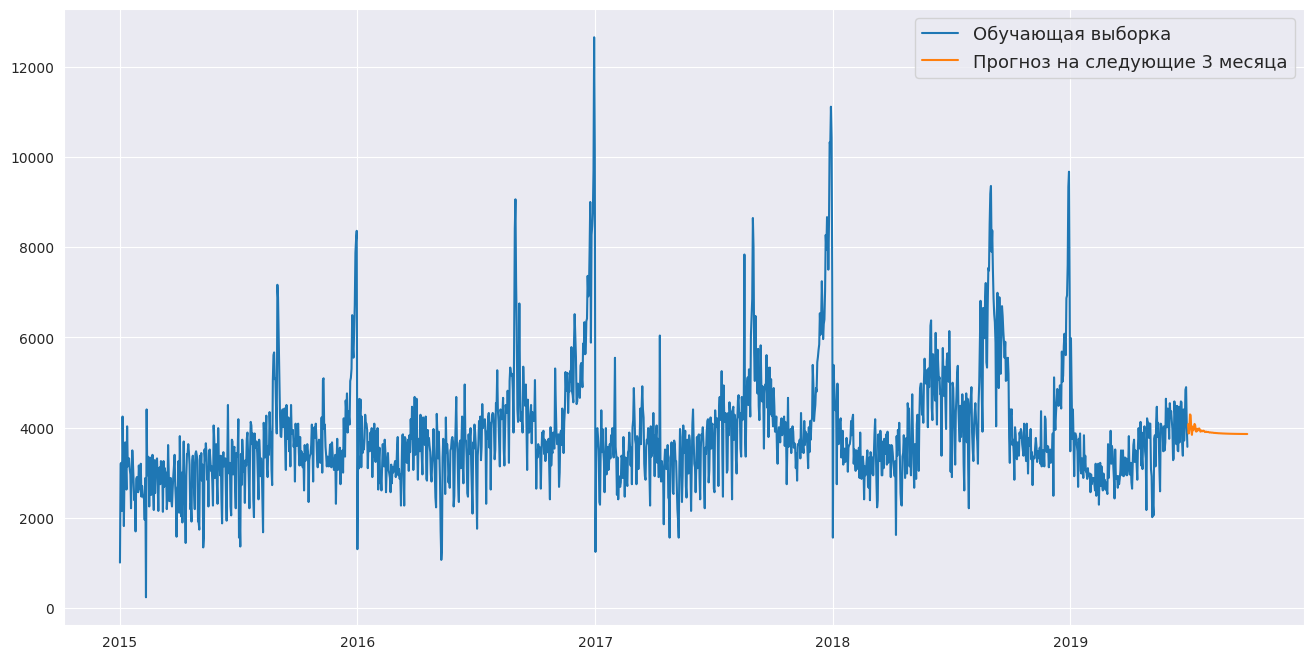

In [54]:
plt.plot(df, label = 'Обучающая выборка')
plt.plot(pred, label = 'Прогноз на следующие 3 месяца')

plt.legend(fontsize=13)
plt.show()

In [82]:
#pred.to_excel('task_1.xlsx',  index_label='Date')